In [ ]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>


# Intro

I recently published a post about applying [deep learning to the stock market](https://medium.com/@TalPerry/deep-learning-the-stock-market-df853d139e02#.e33ao345g). This Notebook is an initial sketch of the implementation. People approach the market to make money, and I am no exception, so it may come as some suprise that I am giving this away. In fact, I don't think this implementation does make money. But it does illustrate a variety of concepts that are important for data science, deep learning and the application of both to finance. I learnt almost everything I know from tutorials like this one on the internet, and I hope someone will learn a thing or two from this

## What's in this thing?

This notebook goes through the full the process of implementing the ideas I layed out in the post. That is it covers
* Preparing the data
* Building a baseline
* Implementing a DL model

## A (more or less) standard data science work flow

### Defining the problem you want to solve
I think all three of those stages are important, and in many respects they are ordered by both importance and the order in which I approach them. My first step in this process was writing that post (4.5K words) explaining in relatively simple terms what I want to do and why. 

### Collecting data
The next stage was collecting data, this actually took me a while and I ended up going with a freely availble dataset you can download [here](https://quantquote.com/historical-stock-data). 

### Reconciling the problem and the data
Once I had an idea of what problem I wanted to solve and I had some data I went about getting the data into a shape  I could work with. 

### Making a baseline
Next I built a baseline model. A baseline doesn't need to be good, but it needs to be something you can compare your actual model to, so that you can know if all the fancy complicated things you did are any better than something simple. This is also a good point to choose how to measure your models performance.

### Testing the idea
I ended up bulding to baselines. One is a simple logistic regression and the other is a 3 layer feed forward network, or if you like big words, a multi layer perceptron. I made the first because I wanted a baseline and the second because I wanted to see if the additional complexity and computation cost of an RNN added benefit over a simpler network

# Data Prepaparation
Maybe its different for the more fortunate but in my experience 80% of the work in data science is data engineering. If I had to break that down even more it would be 20% "science", 20% engineering and 60% finding the right, clean data. 
For the project at hand I wanted a lot of data for many stocks. My "production" version uses slightly different data but for the POC using 10 years of the S&P was enough to prover my point.

In case you missed it, the S&P500 is an index of 500 stocks that is updated once every 3 months. For POC purposes using daily data is sufficient and I ended up finding a free data set [here](https://quantquote.com/historical-stock-data). You can download it and point the *datapath* variable to point at it and runs this notebook yourself
This notebook explores the data, joins all the stocks and creates targets


## preliminaries
So first we need to import some libraries and define some helper functions
* **get_ticker** applies a regex to the filename we are looking at and extracts the ticker from it
* **ret calculates** to log return between two points. Returns should be observed in log space because
    * Returns are log-normally distributed so log returns are follow a normal distribution
    * You can some log returns instead of taking products which makes life easier
* **zscore** maps a pandas series to it's zscore. In other words, it makes it have mean 0 and variance 1
    * It's good to have variablised normalized like this as it makes all of the dimensions of your data behave the same
    * It doesn't make sense to apply a z-score to distributions that don't (more or less) folllow the normal distribution. So check your variables first and if they don't follow a normal distribution transform them so that they do are use other scaling methods

In [2]:
import pandas as pd
import os
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
datapath = '../util/stock_dfs/'
filepath = os.path.join(datapath,os.listdir(datapath)[0])

In [4]:
import re
ticker_regex = re.compile('.+_(?P<ticker>.+)\.csv')
#get_ticker =lambda x :ticker_regex.match(x).groupdict()['ticker'] -- use my own function to get ticker
get_ticker = lambda x:x.split('/')[-1].split('.')[0]
print(filepath,get_ticker(filepath))

../util/stock_dfs/.DS_Store 


In [5]:
ret = lambda x,y: log(y/x) #Log return 
zscore = lambda x:(x -x.mean())/x.std() # zscore

## First peak at the data
I blah blahed alot without actually looking at the data. lets load it. I use the pandas library to rad a single CSV. Since the data had no column headers I specified them. I don't know what the first column is so I labeled it UNK.
Notice that the index, which is the real first column in the original data, is a date but in a string pandas didn't understand. We're going to parse it to a datetime object later so that pandas preserves the right order. 

In [5]:
D = pd.read_csv(filepath, parse_dates=['Date'])
D.dtypes

ValueError: 'Date' is not in list

In [7]:
D.head() #Lets peack at it

,Date,Open,High,Low,Close,Adj Close,Volume
0,2008-01-02,26.230330,26.323318,25.836910,25.965666,24.504511,2598700
1,2008-01-03,25.965666,26.001431,25.658083,25.708155,24.261494,2789500
2,2008-01-04,25.450644,25.643776,24.835480,24.871244,23.471676,4939200
3,2008-01-07,25.278971,25.665236,25.071531,25.278971,23.856462,4901100
4,2008-01-08,25.293276,25.572247,25.143061,25.243204,23.822704,5680700


## Extracting Relevant Data
We don't care about prices, just about their fluctations. So we'll give the log return of the various prices, and take a zscore so everything is nice. 
Also, extract the ticker from the file name and add it to the df as a column.


In [6]:
def make_inputs(filepath):
    D = pd.read_csv(filepath).set_index('Date')
                                          #,header=None,names=['UNK','o','h','l','c','v']) #Load the dataframe with headers
    #D.index = pd.to_datetime(D.index,format='%Y-%m-%d') # Set the indix to a datetime
    Res = pd.DataFrame()
    ticker = get_ticker(filepath)

    Res['c_2_o'] = zscore(ret(D.Open,D.Close))
    Res['h_2_o'] = zscore(ret(D.Open,D.High))
    Res['l_2_o'] = zscore(ret(D.Open,D.Low))
    Res['c_2_h'] = zscore(ret(D.High,D.Close))
    Res['h_2_l'] = zscore(ret(D.High,D.Low))
    Res['c1_c0'] = ret(D.Close,D.Close.shift(-1)).fillna(0) #Tommorows return 
    Res['vol'] = zscore(D.Volume)
    Res['ticker'] = ticker
    return Res
#Res = make_inputs(filepath)

In [9]:
Res.head() # Lets look at what we got

,c_2_o,h_2_o,l_2_o,c_2_h,h_2_l,c1_c0,vol,ticker
Date,,,,,,,,
2008-01-02,-0.603321,-0.708941,-0.208379,-0.155152,0.379177,-0.009967,-0.636741,A
2008-01-03,-0.593552,-0.882954,0.036739,0.029837,0.712638,-0.033096,-0.556092,A
2008-01-04,-1.325307,-0.385348,-0.925942,-1.493744,-0.453307,0.016261,0.352556,A
2008-01-07,-0.035187,0.226634,0.318732,-0.272674,0.083354,-0.001416,0.336452,A
2008-01-08,-0.146201,-0.110993,0.493857,-0.097413,0.486554,0.002547,0.665978,A


In [10]:
Res.corr() #Quick check to see we didn't mess it up. All values should be different, otherwise we repeated a variable

,c_2_o,h_2_o,l_2_o,c_2_h,h_2_l,c1_c0,vol
c_2_o,1.000000,0.706641,0.693055,0.717973,0.015871,-0.000460,-0.016244
h_2_o,0.706641,1.000000,0.204337,0.014828,-0.607545,0.005370,0.339818
l_2_o,0.693055,0.204337,1.000000,0.778360,0.653382,0.018008,-0.335809
c_2_h,0.717973,0.014828,0.778360,1.000000,0.620098,-0.005933,-0.357249
h_2_l,0.015871,-0.607545,0.653382,0.620098,1.000000,0.010459,-0.535274
c1_c0,-0.000460,0.005370,0.018008,-0.005933,0.010459,1.000000,0.029548
vol,-0.016244,0.339818,-0.335809,-0.357249,-0.535274,0.029548,1.000000


## Generating the full data set
I'll iterate over each file, run the above and concat to a final df. Then we'll pivot

In [7]:
Final = pd.DataFrame()
for f in os.listdir(datapath):
    filepath = os.path.join(datapath,f)
    if filepath.endswith('.csv'):
        Res = make_inputs(filepath)
        Final = Final.append(Res)

In [8]:
Final.head()
Final.isnull().any().sum()

6

In [9]:
Final.head()
Final.columns

Index(['c_2_o', 'h_2_o', 'l_2_o', 'c_2_h', 'h_2_l', 'c1_c0', 'vol', 'ticker'], dtype='object')

In [10]:
pivot_columns = Final.columns[:-1]
P = Final.pivot_table(index=Final.index,columns='ticker',values=pivot_columns) # Make a pivot table from the data

In [11]:
P.head()

c1_c0                                                         \
ticker             A       AAL       AAP      AAPL ABBV       ABC       ACN   
Date                                                                          
2008-01-02 -0.009967 -0.046091  0.009531  0.000462  NaN  0.006042 -0.017343   
2008-01-03 -0.033096 -0.024673 -0.061960 -0.079406  NaN -0.023021 -0.015068   
2008-01-04  0.016261 -0.014611  0.044147 -0.013476  NaN  0.013155 -0.027296   
2008-01-07 -0.001416 -0.105088 -0.052876 -0.036635  NaN  0.028215  0.000000   
2008-01-08  0.002547 -0.010959 -0.015102  0.046493  NaN  0.008941 -0.004721   

                                         ...       vol                      \
ticker          ADBE       ADI       ADM ...       XEL        XL      XLNX   
Date                                     ...                                 
2008-01-02  0.001916 -0.015262  0.010331 ... -0.871786 -0.393039  0.682807   
2008-01-03 -0.034818 -0.026424  0.002621 ... -0.989941 -0.504889 -0.400928   
2008-01-04 -0.002978 -0.012783  0.000218 ... -0.365741 -0.536379  0.599084   
2008-01-07 -0.025675 -0.033590 -0.018486 ... -0.540284 -0.271225  0.036374   
2008-01-08  0.006101 -0.014123  0.003769 ... -0.351571 -0.257501  1.300453   

                                                                      
ticker           XOM      XRAY       XRX XYL       ZBH      ZION ZTS  
Date                                                                  
2008-01-02  0.311627 -0.260591 -0.753432 NaN -0.231260 -0.690485 NaN  
2008-01-03 -0.047999 -0.547116 -0.889366 NaN -0.142855 -0.857160 NaN  
2008-01-04  0.429950 -0.288010 -0.852734 NaN  0.557788 -0.697810 NaN  
2008-01-07  0.790889 -0.302766 -0.672058 NaN  1.006898 -0.411987 NaN  
2008-01-08  0.175424  0.278874 -0.832352 NaN  2.827988 -0.153840 NaN  

[5 rows x 2968 columns]

### Flattening the pivot
source http://stackoverflow.com/questions/14507794/python-pandas-how-to-flatten-a-hierarchical-index-in-columns
At the end of this P is a flattened dataframe of all the entries for each stock, one day per row

In [12]:
mi = P.columns.tolist()
mi

[('c1_c0', 'A'),
 ('c1_c0', 'AAL'),
 ('c1_c0', 'AAP'),
 ('c1_c0', 'AAPL'),
 ('c1_c0', 'ABBV'),
 ('c1_c0', 'ABC'),
 ('c1_c0', 'ACN'),
 ('c1_c0', 'ADBE'),
 ('c1_c0', 'ADI'),
 ('c1_c0', 'ADM'),
 ('c1_c0', 'ADSK'),
 ('c1_c0', 'AEE'),
 ('c1_c0', 'AEP'),
 ('c1_c0', 'AES'),
 ('c1_c0', 'AET'),
 ('c1_c0', 'AFL'),
 ('c1_c0', 'AGN'),
 ('c1_c0', 'AIG'),
 ('c1_c0', 'AIV'),
 ('c1_c0', 'AIZ'),
 ('c1_c0', 'AJG'),
 ('c1_c0', 'AKAM'),
 ('c1_c0', 'ALB'),
 ('c1_c0', 'ALK'),
 ('c1_c0', 'ALL'),
 ('c1_c0', 'ALLE'),
 ('c1_c0', 'ALXN'),
 ('c1_c0', 'AMAT'),
 ('c1_c0', 'AMD'),
 ('c1_c0', 'AME'),
 ('c1_c0', 'AMG'),
 ('c1_c0', 'AMGN'),
 ('c1_c0', 'AMP'),
 ('c1_c0', 'AMT'),
 ('c1_c0', 'ANSS'),
 ('c1_c0', 'ANTM'),
 ('c1_c0', 'AON'),
 ('c1_c0', 'AOS'),
 ('c1_c0', 'APA'),
 ('c1_c0', 'APC'),
 ('c1_c0', 'APD'),
 ('c1_c0', 'APH'),
 ('c1_c0', 'ARE'),
 ('c1_c0', 'ARNC'),
 ('c1_c0', 'ATVI'),
 ('c1_c0', 'AVB'),
 ('c1_c0', 'AVGO'),
 ('c1_c0', 'AVY'),
 ('c1_c0', 'AYI'),
 ('c1_c0', 'AZO'),
 ('c1_c0', 'BA'),
 ('c1_c0', 'BAX'),
 

In [13]:
new_ind = pd.Index(e[1] +'_' + e[0] for e in mi)
new_ind

Index(['A_c1_c0', 'AAL_c1_c0', 'AAP_c1_c0', 'AAPL_c1_c0', 'ABBV_c1_c0',
       'ABC_c1_c0', 'ACN_c1_c0', 'ADBE_c1_c0', 'ADI_c1_c0', 'ADM_c1_c0',
       ...
       'XEL_vol', 'XL_vol', 'XLNX_vol', 'XOM_vol', 'XRAY_vol', 'XRX_vol',
       'XYL_vol', 'ZBH_vol', 'ZION_vol', 'ZTS_vol'],
      dtype='object', length=2968)

In [14]:
P.columns = new_ind
#P = P.sort_values(by=new_ind) # Sort by columns -- what is the purpose of this?
P.head()

,A_c1_c0,AAL_c1_c0,AAP_c1_c0,AAPL_c1_c0,ABBV_c1_c0,ABC_c1_c0,ACN_c1_c0,ADBE_c1_c0,ADI_c1_c0,ADM_c1_c0,...,XEL_vol,XL_vol,XLNX_vol,XOM_vol,XRAY_vol,XRX_vol,XYL_vol,ZBH_vol,ZION_vol,ZTS_vol
Date,,,,,,,,,,,,,,,,,,,,,
2008-01-02,-0.009967,-0.046091,0.009531,0.000462,NaN,0.006042,-0.017343,0.001916,-0.015262,0.010331,...,-0.871786,-0.393039,0.682807,0.311627,-0.260591,-0.753432,NaN,-0.231260,-0.690485,NaN
2008-01-03,-0.033096,-0.024673,-0.061960,-0.079406,NaN,-0.023021,-0.015068,-0.034818,-0.026424,0.002621,...,-0.989941,-0.504889,-0.400928,-0.047999,-0.547116,-0.889366,NaN,-0.142855,-0.857160,NaN
2008-01-04,0.016261,-0.014611,0.044147,-0.013476,NaN,0.013155,-0.027296,-0.002978,-0.012783,0.000218,...,-0.365741,-0.536379,0.599084,0.429950,-0.288010,-0.852734,NaN,0.557788,-0.697810,NaN
2008-01-07,-0.001416,-0.105088,-0.052876,-0.036635,NaN,0.028215,0.000000,-0.025675,-0.033590,-0.018486,...,-0.540284,-0.271225,0.036374,0.790889,-0.302766,-0.672058,NaN,1.006898,-0.411987,NaN
2008-01-08,0.002547,-0.010959,-0.015102,0.046493,NaN,0.008941,-0.004721,0.006101,-0.014123,0.003769,...,-0.351571,-0.257501,1.300453,0.175424,0.278874,-0.832352,NaN,2.827988,-0.153840,NaN


In [15]:
clean_and_flat = P.dropna(1)
clean_and_flat.shape

(2267, 2610)

In [16]:
target_cols = list(filter(lambda x: 'c1_c0' in x, clean_and_flat.columns.values))
input_cols  = list(filter(lambda x: 'c1_c0' not in x, clean_and_flat.columns.values))

In [17]:
target_cols
input_cols

['A_c_2_h',
 'AAL_c_2_h',
 'AAP_c_2_h',
 'AAPL_c_2_h',
 'ABC_c_2_h',
 'ACN_c_2_h',
 'ADBE_c_2_h',
 'ADI_c_2_h',
 'ADM_c_2_h',
 'ADSK_c_2_h',
 'AEE_c_2_h',
 'AEP_c_2_h',
 'AES_c_2_h',
 'AET_c_2_h',
 'AFL_c_2_h',
 'AGN_c_2_h',
 'AIG_c_2_h',
 'AIV_c_2_h',
 'AIZ_c_2_h',
 'AJG_c_2_h',
 'AKAM_c_2_h',
 'ALB_c_2_h',
 'ALK_c_2_h',
 'ALL_c_2_h',
 'ALXN_c_2_h',
 'AMAT_c_2_h',
 'AMD_c_2_h',
 'AME_c_2_h',
 'AMG_c_2_h',
 'AMGN_c_2_h',
 'AMP_c_2_h',
 'AMT_c_2_h',
 'ANSS_c_2_h',
 'ANTM_c_2_h',
 'AON_c_2_h',
 'APA_c_2_h',
 'APC_c_2_h',
 'APD_c_2_h',
 'APH_c_2_h',
 'ARE_c_2_h',
 'ARNC_c_2_h',
 'ATVI_c_2_h',
 'AVB_c_2_h',
 'AVY_c_2_h',
 'AYI_c_2_h',
 'AZO_c_2_h',
 'BA_c_2_h',
 'BAX_c_2_h',
 'BBT_c_2_h',
 'BCR_c_2_h',
 'BDX_c_2_h',
 'BEN_c_2_h',
 'BHGE_c_2_h',
 'BIIB_c_2_h',
 'BK_c_2_h',
 'BLL_c_2_h',
 'BMY_c_2_h',
 'BWA_c_2_h',
 'BXP_c_2_h',
 'CA_c_2_h',
 'CAH_c_2_h',
 'CB_c_2_h',
 'CBS_c_2_h',
 'CCI_c_2_h',
 'CDNS_c_2_h',
 'CELG_c_2_h',
 'CERN_c_2_h',
 'CF_c_2_h',
 'CHK_c_2_h',
 'CHRW_c_2_h',
 'CI_c_2_h

In [19]:
InputDF = clean_and_flat[input_cols]#[:3900]
TargetDF = clean_and_flat[target_cols]#[:3900]
InputDF.head()
TargetDF.head()

,A_c1_c0,AAL_c1_c0,AAP_c1_c0,AAPL_c1_c0,ABC_c1_c0,ACN_c1_c0,ADBE_c1_c0,ADI_c1_c0,ADM_c1_c0,ADSK_c1_c0,...,WYNN_c1_c0,XEC_c1_c0,XEL_c1_c0,XL_c1_c0,XLNX_c1_c0,XOM_c1_c0,XRAY_c1_c0,XRX_c1_c0,ZBH_c1_c0,ZION_c1_c0
Date,,,,,,,,,,,,,,,,,,,,,
2008-01-02,-0.009967,-0.046091,0.009531,0.000462,0.006042,-0.017343,0.001916,-0.015262,0.010331,-0.008326,...,-0.034412,0.000463,0.005847,0.010907,-0.005222,0.003416,0.009334,-0.007614,0.001055,-0.020297
2008-01-03,-0.033096,-0.024673,-0.061960,-0.079406,-0.023021,-0.015068,-0.034818,-0.026424,0.002621,-0.045764,...,-0.004552,-0.030316,-0.011274,-0.016105,-0.031426,-0.018827,-0.019449,-0.038304,0.002107,-0.045641
2008-01-04,0.016261,-0.014611,0.044147,-0.013476,0.013155,-0.027296,-0.002978,-0.012783,0.000218,0.022074,...,-0.009359,0.001669,0.015302,0.031373,0.004899,-0.009384,0.023745,-0.000662,0.031965,0.020542
2008-01-07,-0.001416,-0.105088,-0.052876,-0.036635,0.028215,0.000000,-0.025675,-0.033590,-0.018486,-0.041518,...,0.002683,0.008303,-0.010326,-0.072078,-0.037853,-0.012909,0.005401,-0.018717,-0.020750,-0.035752
2008-01-08,0.002547,-0.010959,-0.015102,0.046493,0.008941,-0.004721,0.006101,-0.014123,0.003769,-0.009640,...,0.035349,0.024733,0.017003,-0.008386,0.015114,0.016629,0.027666,0.012073,0.005339,0.002153


In [58]:
a = np.cumprod(TargetDF+1,axis=0)
a

,A_c1_c0,AAL_c1_c0,AAP_c1_c0,AAPL_c1_c0,ABC_c1_c0,ACN_c1_c0,ADBE_c1_c0,ADI_c1_c0,ADM_c1_c0,ADSK_c1_c0,...,WYNN_c1_c0,XEC_c1_c0,XEL_c1_c0,XL_c1_c0,XLNX_c1_c0,XOM_c1_c0,XRAY_c1_c0,XRX_c1_c0,ZBH_c1_c0,ZION_c1_c0
Date,,,,,,,,,,,,,,,,,,,,,
2008-01-02,0.990033,0.953909,1.009531,1.000462,1.006042,0.982657,1.001916,0.984738,1.010331,0.991674,...,0.965588,1.000463,1.005847,1.010907,0.994778,1.003416,1.009334,0.992386,1.001055,0.979703
2008-01-03,0.957267,0.930373,0.946981,0.921019,0.982883,0.967850,0.967032,0.958717,1.012979,0.946291,...,0.961192,0.970133,0.994507,0.994626,0.963516,0.984525,0.989703,0.954374,1.003165,0.934989
2008-01-04,0.972833,0.916780,0.988788,0.908608,0.995813,0.941432,0.964152,0.946461,1.013200,0.967179,...,0.952196,0.971752,1.009724,1.025831,0.968237,0.975287,1.013204,0.953742,1.035231,0.954195
2008-01-07,0.971455,0.820437,0.936505,0.875321,1.023909,0.941432,0.939398,0.914670,0.994469,0.927024,...,0.954751,0.979820,0.999298,0.951891,0.931586,0.962697,1.018676,0.935890,1.013750,0.920081
2008-01-08,0.973930,0.811446,0.922362,0.916018,1.033064,0.936988,0.945129,0.901752,0.998217,0.918087,...,0.988500,1.004054,1.016289,0.943909,0.945665,0.978706,1.046859,0.947189,1.019163,0.922062
2008-01-09,1.016744,0.926571,0.889749,0.908945,1.047541,0.931429,0.940085,0.909610,0.984651,0.923655,...,0.995143,0.997088,1.025714,0.994211,0.952262,0.979774,1.057771,0.927409,1.032640,0.962580
2008-01-10,0.989711,0.876514,0.847197,0.881315,1.060911,0.908422,0.910895,0.871326,0.963667,0.892527,...,0.934436,1.003316,1.017111,0.986041,0.922486,0.965128,1.065965,0.901156,1.054120,0.968067
2008-01-11,1.007151,0.887503,0.843489,0.911859,1.059116,0.928425,0.921132,0.893387,0.996234,0.915785,...,0.919833,1.020067,1.017111,1.010926,0.937021,0.970776,1.049385,0.914312,1.036492,0.963212
2008-01-14,0.989124,0.921489,0.824509,0.860776,1.028170,0.927870,0.907628,0.868744,0.993139,0.880611,...,0.889262,0.990967,1.010326,1.010728,0.899912,0.951235,1.033268,0.882859,1.019631,0.939368


In [20]:
corrs = TargetDF.corr()
TargetDF.shape
InputDF.columns

Index(['A_c_2_h', 'AAL_c_2_h', 'AAP_c_2_h', 'AAPL_c_2_h', 'ABC_c_2_h',
       'ACN_c_2_h', 'ADBE_c_2_h', 'ADI_c_2_h', 'ADM_c_2_h', 'ADSK_c_2_h',
       ...
       'WYNN_vol', 'XEC_vol', 'XEL_vol', 'XL_vol', 'XLNX_vol', 'XOM_vol',
       'XRAY_vol', 'XRX_vol', 'ZBH_vol', 'ZION_vol'],
      dtype='object', length=2226)

## Generating Targets
We now have an our inputs and targets, kind of. 
InputsDF has all the inputs we want to predict. Targets DF has the return of each stock each day. 
For starters, lets give a simpler target to predict than the reuturn of each stock, since we don't have much data. 


We're going to label the targets as either up (1) down (-1) or flat (0) days.
The top chart shows what would happen if we bought 1 dollar of ewach stock each day
The bottom chart shows what would happen if we longed the whole basket on (1) days, shorted it on down days (-1) and ignored it on  (0) days. 
You can see that this is a valuable target to predict.

In [21]:
num_stocks = len(TargetDF.columns)
num_stocks

384

In [60]:
TotalReturn = ((1-exp(TargetDF)).sum(1))/num_stocks # If i put one dollar in each stock at the close, this is how much I'd get back
TotalReturn

Date
2008-01-02    0.005537
2008-01-03    0.027668
2008-01-04   -0.001168
2008-01-07    0.020450
2008-01-08   -0.010201
2008-01-09   -0.012981
2008-01-10    0.015233
2008-01-11   -0.010236
2008-01-14    0.023431
2008-01-15   -0.001856
2008-01-16    0.027260
2008-01-17    0.004273
2008-01-18    0.003663
2008-01-22   -0.028865
2008-01-23   -0.009122
2008-01-24    0.011444
2008-01-25   -0.019774
2008-01-28   -0.007806
2008-01-29    0.006696
2008-01-30   -0.018555
2008-01-31   -0.022125
2008-02-01    0.011211
2008-02-04    0.028636
2008-02-05    0.007408
2008-02-06   -0.011387
2008-02-07    0.004055
2008-02-08   -0.004944
2008-02-11   -0.006074
2008-02-12   -0.012791
2008-02-13    0.014493
                ...   
2016-11-17    0.002608
2016-11-18   -0.008021
2016-11-21   -0.002510
2016-11-22   -0.002956
2016-11-23   -0.003612
2016-11-25    0.006032
2016-11-28   -0.001053
2016-11-29    0.000409
2016-11-30    0.003930
2016-12-01   -0.001595
2016-12-02   -0.006931
2016-12-05   -0.004346
2016-1

In [23]:
def labeler(x):
    if x>0.0029:
        return 1
    if x<-0.00462:
        return -1
    else:
        return 0

In [24]:
Labeled = pd.DataFrame()
Labeled['return'] = TotalReturn
Labeled['class'] = TotalReturn.apply(labeler,1)
Labeled['multi_class'] = pd.qcut(TotalReturn,11,labels=range(11))
Labeled.head()

,return,class,multi_class
Date,,,
2008-01-02,0.005537,1,8
2008-01-03,0.027668,1,10
2008-01-04,-0.001168,0,5
2008-01-07,0.020450,1,10
2008-01-08,-0.010201,-1,1


In [25]:
pd.qcut(TotalReturn,5).unique()

[(0.00121, 0.0072], (0.0072, 0.103], (-0.00303, 0.00121], (-0.117, -0.00855], (-0.00855, -0.00303]]
Categories (5, interval[float64]): [(-0.117, -0.00855] < (-0.00855, -0.00303] < (-0.00303, 0.00121] < (0.00121, 0.0072] < (0.0072, 0.103]]

In [26]:
def labeler_multi(x):
    if x>0.0029:
        return 1
    if x<-0.00462:
        return -1
    else:
        return 0

In [27]:
Labeled['class'].value_counts()

 0    776
-1    759
 1    732
Name: class, dtype: int64

In [28]:
Labeled['act_return'] = Labeled['class'] * Labeled['return']

array([<matplotlib.axes._subplots.AxesSubplot object at 0x11a79ceb8>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x11b3d72e8>], dtype=object)

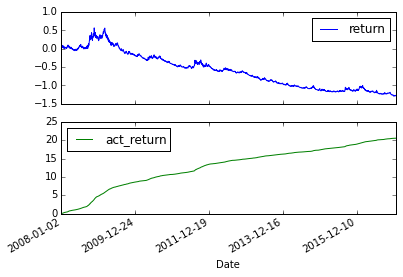

In [29]:
Labeled[['return','act_return']].cumsum().plot(subplots=True)

# Making a baseline

## Logistic Regression

In [30]:
from sklearn import linear_model
logreg = linear_model.LogisticRegression(C=1e5)

In [31]:
test_size=600

In [32]:
res = logreg.fit(InputDF[:-test_size],Labeled['multi_class'][:-test_size])

In [33]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(Labeled['multi_class'][-test_size:],res.predict(InputDF[-test_size:])))
print(confusion_matrix(Labeled['multi_class'][-test_size:],res.predict(InputDF[-test_size:])))

             precision    recall  f1-score   support

          0       0.11      0.03      0.05        31
          1       0.12      0.14      0.13        57
          2       0.11      0.12      0.11        43
          3       0.07      0.08      0.07        59
          4       0.05      0.09      0.06        55
          5       0.16      0.08      0.11        72
          6       0.15      0.28      0.19        68
          7       0.12      0.11      0.11        64
          8       0.17      0.10      0.13        67
          9       0.03      0.02      0.02        53
         10       0.00      0.00      0.00        31

avg / total       0.11      0.11      0.10       600

[[ 1  3  2 11  3  0  2  2  4  3  0]
 [ 0  8  6  5  8  2 13  7  3  2  3]
 [ 1  4  5  7  4  1 12  3  2  4  0]
 [ 1  6  2  5 18  3  7  8  6  3  0]
 [ 0 10  2 10  5  6 10  5  3  3  1]
 [ 2  5  9  9  7  6 19  9  4  1  1]
 [ 0  9  4  9 11  3 19  6  2  5  0]
 [ 2  7  4  3 13  4 14  7  4  6  0]
 [ 1  3  5  4 17  5 

In [34]:
Labeled['predicted_action'] = list(map(lambda x: -1 if x <5 else 0 if x==5 else 1,res.predict(InputDF)))
print(confusion_matrix(Labeled['class'][-test_size:],Labeled['predicted_action'][-test_size:]))

[[ 87   4  76]
 [118  19 110]
 [ 91  14  81]]


In [35]:
Labeled['pred_return'] = Labeled['predicted_action'] * Labeled['return']

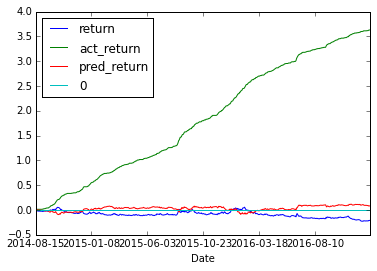

In [36]:
Res = Labeled[-test_size:][['return','act_return','pred_return']].cumsum()
Res[0] =0
Res.plot()

## Training a basic feed forward network
Here I'll use the tensorflow contrib.learn to quickly train a feed forward network. More of a benchmark than something I plan on using

In [37]:
import tensorflow as tf
from  tensorflow.contrib.learn.python.learn.estimators.dnn  import DNNClassifier
from tensorflow.contrib.layers import real_valued_column

In [38]:
Labeled['tf_class'] = Labeled['multi_class']
num_features = len(InputDF.columns)
dropout=0.2
hidden_1_size = 1000
hidden_2_size = 250
num_classes = Labeled.tf_class.nunique()
NUM_EPOCHS=100
BATCH_SIZE=50
lr=0.0001

In [39]:
test_size=600
train = (InputDF[:-test_size].values,Labeled.tf_class[:-test_size].values)
val = (InputDF[-test_size:].values,Labeled.tf_class[-test_size:].values)
NUM_TRAIN_BATCHES = int(len(train[0])/BATCH_SIZE)
NUM_VAL_BATCHES = int(len(val[1])/BATCH_SIZE)

In [40]:
len(InputDF)

2267

In [41]:
class Model():
    def __init__(self):
        global_step = tf.contrib.framework.get_or_create_global_step()
        self.input_data = tf.placeholder(dtype=tf.float32,shape=[None,num_features])
        self.target_data = tf.placeholder(dtype=tf.int32,shape=[None])
        self.dropout_prob = tf.placeholder(dtype=tf.float32,shape=[])
        with tf.variable_scope("ff"):
            droped_input = tf.nn.dropout(self.input_data,keep_prob=self.dropout_prob)
            
            layer_1 = tf.contrib.layers.fully_connected(
                num_outputs=hidden_1_size,
                inputs=droped_input,
            )
            layer_2 = tf.contrib.layers.fully_connected(
                num_outputs=hidden_2_size,
                inputs=layer_1,
            )
            self.logits = tf.contrib.layers.fully_connected(
                num_outputs=num_classes,
                activation_fn =None,
                inputs=layer_2,
            )
        with tf.variable_scope("loss"):
            
            #self.losses = tf.nn.sparse_softmax_cross_entropy_with_logits(self.logits,self.target_data)
            self.losses = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=self.logits,labels=self.target_data)
            mask = (1-tf.sign(1-self.target_data)) #Don't give credit for flat days
            mask = tf.cast(mask,tf.float32)
            self.loss = tf.reduce_sum(self.losses)
        
        with tf.name_scope("train"):
          opt = tf.train.AdamOptimizer(lr)
          gvs = opt.compute_gradients(self.loss)
          self.train_op = opt.apply_gradients(gvs, global_step=global_step)
        
        with tf.name_scope("predictions"):
            self.probs = tf.nn.softmax(self.logits)
            self.predictions = tf.argmax(self.probs, 1)
            correct_pred = tf.cast(tf.equal(self.predictions, tf.cast(self.target_data,tf.int64)),tf.float64)
            self.accuracy = tf.reduce_mean(correct_pred)

In [42]:
with tf.Graph().as_default():
    model = Model()
    input_ = train[0]
    target = train[1]
    with tf.Session() as sess:
        init = tf.initialize_all_variables()
        sess.run([init])
        epoch_loss =0
        for e in range(NUM_EPOCHS):
            if epoch_loss >0 and epoch_loss <1:
                break
            epoch_loss =0
            for batch in range(0,NUM_TRAIN_BATCHES):
                
                start = batch*BATCH_SIZE
                end = start + BATCH_SIZE 
                feed = {
                    model.input_data:input_[start:end],
                    model.target_data:target[start:end],
                    model.dropout_prob:0.9
                            }
                
                _,loss,acc = sess.run(
                    [
                        model.train_op,
                        model.loss,
                        model.accuracy,
                    ]
                    ,feed_dict=feed
                )
                epoch_loss+=loss
            print('step - {0} loss - {1} acc - {2}'.format((1+batch+NUM_TRAIN_BATCHES*e),epoch_loss,acc))
                
        
        print('done training')
        final_preds =np.array([])
        final_probs =None
        for batch in range(0,NUM_VAL_BATCHES):
            
                start = batch*BATCH_SIZE
                end = start + BATCH_SIZE 
                feed = {
                    model.input_data:val[0][start:end],
                    model.target_data:val[1][start:end],
                    model.dropout_prob:1
                            }
                
                acc,preds,probs = sess.run(
                    [
                        model.accuracy,
                        model.predictions,
                        model.probs
                    ]
                    ,feed_dict=feed
                )
                print(acc)
                final_preds = np.concatenate((final_preds,preds),axis=0)
                if final_probs is None:
                    final_probs = probs
                else:
                    final_probs = np.concatenate((final_probs,probs),axis=0)
        prediction_conf = final_probs[np.argmax(final_probs,1)]

Instructions for updating:
Use `tf.global_variables_initializer` instead.
step - 33 loss - 4194.596374511719 acc - 0.16
step - 66 loss - 3622.2659912109375 acc - 0.2
step - 99 loss - 3178.0179901123047 acc - 0.26
step - 132 loss - 2770.670722961426 acc - 0.34
step - 165 loss - 2528.366687774658 acc - 0.52
step - 198 loss - 2325.9197540283203 acc - 0.6
step - 231 loss - 2022.479974746704 acc - 0.66
step - 264 loss - 1598.711835861206 acc - 0.76
step - 297 loss - 1330.40678024292 acc - 0.9
step - 330 loss - 1094.9772100448608 acc - 0.86
step - 363 loss - 932.8193221092224 acc - 0.84
step - 396 loss - 776.7254676818848 acc - 0.9
step - 429 loss - 650.2838759422302 acc - 0.94
step - 462 loss - 524.0797340869904 acc - 0.96
step - 495 loss - 456.4841833114624 acc - 0.96
step - 528 loss - 387.21732354164124 acc - 0.92
step - 561 loss - 361.5056176185608 acc - 1.0
step - 594 loss - 323.998664021492 acc - 1.0
step - 627 loss - 323.063679933548 acc - 0.74
step - 660 loss - 292.4816999435425 acc 

In [43]:
Result = Labeled[-test_size:].copy()

In [44]:
Result['nn_pred'] = final_preds
Result['mod_nn_prod'] = list(map(lambda x: -1 if x <5 else 0 if x==5 else 1,final_preds))
Result['nn_ret'] = Result.mod_nn_prod*Result['return']

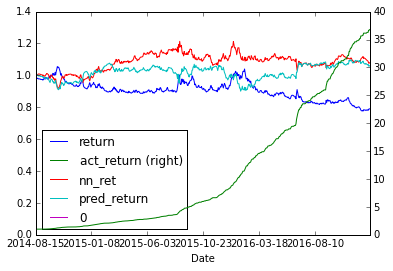

In [45]:
#Res = Result[-test_size:][['return','act_return','pred_return','nn_ret']].cumsum()
Res = (1+Result[-test_size:][['return','act_return','nn_ret','pred_return']]).cumprod()
Res[0] =0
Res.plot(secondary_y='act_return')

In [46]:
print(confusion_matrix(Result['class'],Result['mod_nn_prod']))
print(classification_report(Result['class'],Result['mod_nn_prod']))

[[ 92   6  69]
 [112  16 119]
 [ 93  13  80]]
             precision    recall  f1-score   support

         -1       0.31      0.55      0.40       167
          0       0.46      0.06      0.11       247
          1       0.30      0.43      0.35       186

avg / total       0.37      0.31      0.27       600



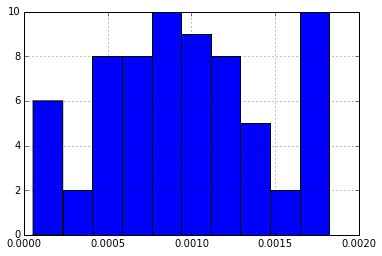

In [47]:
cm = pd.DataFrame(confusion_matrix(Result['multi_class'],Result['nn_pred']))
#sns.heatmap(cm.div(cm.sum(1)))
Result[Result.multi_class==6]['return'].hist()

In [48]:
print(classification_report(Result['multi_class'],Result['nn_pred']))

             precision    recall  f1-score   support

          0       0.11      0.10      0.10        31
          1       0.06      0.07      0.07        57
          2       0.07      0.07      0.07        43
          3       0.09      0.10      0.10        59
          4       0.03      0.05      0.04        55
          5       0.14      0.07      0.09        72
          6       0.15      0.21      0.17        68
          7       0.11      0.08      0.09        64
          8       0.14      0.10      0.12        67
          9       0.02      0.02      0.02        53
         10       0.19      0.23      0.21        31

avg / total       0.10      0.10      0.10       600



array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1232147b8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x12414a470>]], dtype=object)

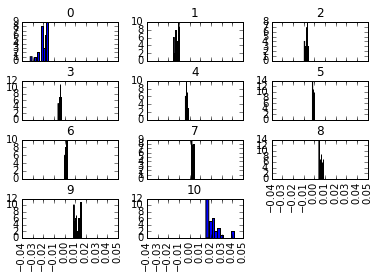

In [49]:
Result.hist(by='multi_class',column='return',sharex=True)

# Main Event - RNN
In this section we'll make an rnn model that learns to take the past into account as well

## Defining an rnn Network

In [50]:
from tensorflow.contrib.layers.python.layers.initializers import xavier_initializer
RNN_HIDDEN_SIZE=100
FIRST_LAYER_SIZE=1000
SECOND_LAYER_SIZE=250
NUM_LAYERS=2
BATCH_SIZE=50
NUM_EPOCHS=200
lr=0.0003
NUM_TRAIN_BATCHES = int(len(train[0])/BATCH_SIZE)
NUM_VAL_BATCHES = int(len(val[1])/BATCH_SIZE)
ATTN_LENGTH=30
beta=0

In [51]:
class RNNModel():
    def __init__(self):
        global_step = tf.contrib.framework.get_or_create_global_step()
        self.input_data = tf.placeholder(dtype=tf.float32,shape=[BATCH_SIZE,num_features])
        self.target_data = tf.placeholder(dtype=tf.int32,shape=[BATCH_SIZE])
        self.dropout_prob = tf.placeholder(dtype=tf.float32,shape=[])
        
        def makeGRUCells():
            base_cell = tf.nn.rnn_cell.GRUCell(num_units=RNN_HIDDEN_SIZE,) 
            layered_cell = tf.nn.rnn_cell.MultiRNNCell([base_cell] * NUM_LAYERS,state_is_tuple=False) 
            attn_cell =tf.contrib.rnn.AttentionCellWrapper(cell=layered_cell,attn_length=ATTN_LENGTH,state_is_tuple=False)
            return attn_cell
        
        self.gru_cell = makeGRUCells()
        self.zero_state = self.gru_cell.zero_state(1, tf.float32)
        
        self.start_state = tf.placeholder(dtype=tf.float32,shape=[1,self.gru_cell.state_size])
        
        

        with tf.variable_scope("ff",initializer=xavier_initializer(uniform=False)):
            droped_input = tf.nn.dropout(self.input_data,keep_prob=self.dropout_prob)
            
            layer_1 = tf.contrib.layers.fully_connected(
                num_outputs=FIRST_LAYER_SIZE,
                inputs=droped_input,
                
            )
            layer_2 = tf.contrib.layers.fully_connected(
                num_outputs=RNN_HIDDEN_SIZE,
                inputs=layer_1,
                
            )
            
        
        split_inputs = tf.reshape(droped_input,shape=[1,BATCH_SIZE,num_features],name="reshape_l1") # Each item in the batch is a time step, iterate through them
        split_inputs = tf.unpack(split_inputs,axis=1,name="unpack_l1")
        states =[]
        outputs =[]
        with tf.variable_scope("rnn",initializer=xavier_initializer(uniform=False)) as scope:
            state = self.start_state
            for i, inp in enumerate(split_inputs):
                if i >0:
                    scope.reuse_variables()
                
                output, state = self.gru_cell(inp, state)
                states.append(state)
                outputs.append(output)
        self.end_state = states[-1]
        outputs = tf.pack(outputs,axis=1) # Pack them back into a single tensor
        outputs = tf.reshape(outputs,shape=[BATCH_SIZE,RNN_HIDDEN_SIZE])
        self.logits = tf.contrib.layers.fully_connected(
            num_outputs=num_classes,
            inputs=outputs,
            activation_fn=None
        )

            
        with tf.variable_scope("loss"):
            self.penalties =    tf.reduce_sum([beta*tf.nn.l2_loss(var) for var in tf.trainable_variables()])

            
            self.losses = tf.nn.sparse_softmax_cross_entropy_with_logits(self.logits,self.target_data)
            self.loss = tf.reduce_sum(self.losses + beta*self.penalties)
        
        with tf.name_scope("train_step"):
          opt = tf.train.AdamOptimizer(lr)
          gvs = opt.compute_gradients(self.loss)
          self.train_op = opt.apply_gradients(gvs, global_step=global_step)
        
        with tf.name_scope("predictions"):
            probs = tf.nn.softmax(self.logits)
            self.predictions = tf.argmax(probs, 1)
            correct_pred = tf.cast(tf.equal(self.predictions, tf.cast(self.target_data,tf.int64)),tf.float64)
            self.accuracy = tf.reduce_mean(correct_pred)

## Training the RNN

In [52]:
with tf.Graph().as_default():
    model = RNNModel()
    input_ = train[0]
    target = train[1]
    with tf.Session() as sess:
        init = tf.initialize_all_variables()
        sess.run([init])
        loss = 2000
        
        for e in range(NUM_EPOCHS):
            state = sess.run(model.zero_state)
            epoch_loss =0
            for batch in range(0,NUM_TRAIN_BATCHES):
                start = batch*BATCH_SIZE
                end = start + BATCH_SIZE 
                feed = {
                    model.input_data:input_[start:end],
                    model.target_data:target[start:end],
                    model.dropout_prob:0.5,
                    model.start_state:state
                            }
                _,loss,acc,state = sess.run(
                    [
                        model.train_op,
                        model.loss,
                        model.accuracy,
                        model.end_state
                    ]
                    ,feed_dict=feed
                )
                epoch_loss+=loss
                
            print('step - {0} loss - {1} acc - {2}'.format((e),epoch_loss,acc))
        final_preds =np.array([])
        for batch in range(0,NUM_VAL_BATCHES):
                start = batch*BATCH_SIZE
                end = start + BATCH_SIZE 
                feed = {
                    model.input_data:val[0][start:end],
                    model.target_data:val[1][start:end],
                    model.dropout_prob:1,
                    model.start_state:state
                            }
                acc,preds,state = sess.run(
                    [
                        model.accuracy,
                        model.predictions,
                        model.end_state
                    ]
                    ,feed_dict=feed
                )
                print(acc)
                assert len(preds) == BATCH_SIZE
                final_preds = np.concatenate((final_preds,preds),axis=0)

AttributeError: module 'tensorflow' has no attribute 'unpack'

## RNN Results

In [ ]:
Result['rnn_pred'] = final_preds
Result['mod_rnn_prod'] = list(map(lambda x: -1 if x <5 else 0 if x==5 else 1,final_preds))
Result['rnn_ret'] = Result.mod_rnn_prod*Result['return']

In [ ]:
print(confusion_matrix(Result['multi_class'],Result['rnn_pred']))
print(classification_report(Result['class'],Result['mod_rnn_prod']))
print(confusion_matrix(Result['class'],Result['mod_rnn_prod']))

In [ ]:
(96/(96+82) + 94/(77+94))/2

In [ ]:
Res = (Result[-test_size:][['return','nn_ret','rnn_ret','pred_return']]).cumsum()
Res[0] =0
Res.plot(figsize=(20,10))

In [ ]:
Res.columns =['Market Baseline','Simple Neural Newtwork','My Algo','Logistic Regression (simple ML)','Do Nothing(0)']
Res.plot(figsize=(20,10),title="Performance of MarketVectors algo over 27 months compared with baselines")

In [ ]:
Res.columns
Res.columns =['baseline','logistic_regression','feed_forward_net','rnn_net','do_nothing']
Res.plot(figsize=(20,10))

In [ ]:
from tensorflow.python.ops.rnn_cell import BasicLSTMCell, GRUCell, MultiRNNCell, DropoutWrapper
cell = tf.nn.rnn_cell.GRUCell(num_units=RNN_HIDDEN_SIZE)
cell = MultiRNNCell(cells=[cell]*NUM_LAYERS,state_is_tuple=True)
attn_cell =tf.contrib.rnn.AttentionCellWrapper(cell=cell,attn_length=ATTN_LENGTH,state_is_tuple=True)
print(attn_cell.zero_state(batch_size=1,dtype=tf.float32))

In [ ]:
model.start_state

In [ ]:
sess = tf.InteractiveSession()

In [ ]:
x = ([1,2,3,4],())
y = sum([1,2,3],())
type(())

In [ ]:
Labeled.hist(column='return',by='class')

In [ ]:
Result['class'].unique()

In [ ]:
import seaborn as sns
g = sns.FacetGrid(Result, row="class", col="rnn_pred", margin_titles=True)
g.map(sns.distplot, "return",);

In [ ]:
Result.hist(by=['class','nn_pred'],column='return',sharex=True)

In [ ]:
Result['zreturn'] = zscore(Result['return'])
Result['day'] = Result.index.dayofweek
sns.lmplot(data=Result,y='zreturn',x='nn_prediction_conf',hue='day',col='class',row='nn_pred',fit_reg=False)

In [ ]:
Result.index.dayofweek

In [ ]:
Res.rnn_ret.mean()/Res.rnn_ret.std()